In [1]:
# VERIFY the path
from pathlib import Path

DATA_PATH = Path(r"F:/unified/fraud transaction detection/dataset")

print("Path exists:", DATA_PATH.exists())
print("Files found:")
print(list(DATA_PATH.iterdir()))


Path exists: True
Files found:
[WindowsPath('F:/unified/fraud transaction detection/dataset/data'), WindowsPath('F:/unified/fraud transaction detection/dataset/Fraud Transaction Detection .pdf')]


In [2]:
from pathlib import Path
DATA_PATH = Path(r"F:/unified/fraud transaction detection/dataset/data")

In [3]:
#load dataset
import pandas as pd

# Collect all daily pickle files
files = sorted(DATA_PATH.glob("*.pkl"))

print(f"Total daily files found: {len(files)}")

df_list = []
for file in files:
    daily_df = pd.read_pickle(file)
    df_list.append(daily_df)

# Merge all days into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Sort by time (important for fraud patterns)
df = df.sort_values("TX_DATETIME").reset_index(drop=True)

df.head()

Total daily files found: 183


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [4]:
#STEP 2: Basic Data Inspection
# Check structure
df.info()

# Fraud distribution
fraud_ratio = df["TX_FRAUD"].value_counts(normalize=True)
print(fraud_ratio)

# Missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB
TX_FRAUD
0    0.991631
1    0.008369
Name: proportion, dtype: float64


TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

<Figure size 600x400 with 0 Axes>

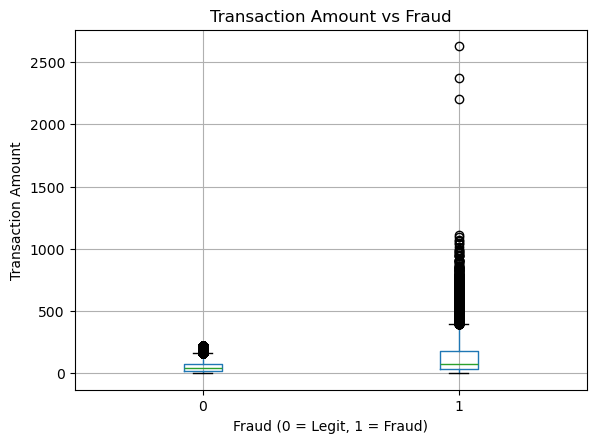

In [5]:
#STEP 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df.boxplot(column="TX_AMOUNT", by="TX_FRAUD")
plt.title("Transaction Amount vs Fraud")
plt.suptitle("")
plt.xlabel("Fraud (0 = Legit, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.show()


In [6]:
#STEP 4: Feature Engineering
df["TX_HOUR"] = df["TX_DATETIME"].dt.hour
df["TX_DAY"] = df["TX_DATETIME"].dt.day
df["TX_DAYOFWEEK"] = df["TX_DATETIME"].dt.dayofweek
df["IS_WEEKEND"] = df["TX_DAYOFWEEK"].isin([5,6]).astype(int)


In [7]:
#Customer Behavior Features
# Average amount per customer
df["CUST_AVG_AMOUNT"] = df.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("mean")

# Number of transactions per customer
df["CUST_TX_COUNT"] = df.groupby("CUSTOMER_ID")["TX_AMOUNT"].transform("count")

# How much this transaction deviates from customer's normal spending
df["AMOUNT_DEVIATION"] = df["TX_AMOUNT"] - df["CUST_AVG_AMOUNT"]

In [8]:
#Terminal Risk Features
# Total transactions per terminal
df["TERMINAL_TX_COUNT"] = df.groupby("TERMINAL_ID")["TX_AMOUNT"].transform("count")

# Fraud rate per terminal
terminal_fraud_rate = df.groupby("TERMINAL_ID")["TX_FRAUD"].mean()
df["TERMINAL_FRAUD_RATE"] = df["TERMINAL_ID"].map(terminal_fraud_rate)


In [9]:
#STEP 5: Prepare Data for Modeling
from sklearn.model_selection import train_test_split

FEATURES = [
    "TX_AMOUNT",
    "TX_HOUR",
    "TX_DAYOFWEEK",
    "IS_WEEKEND",
    "CUST_AVG_AMOUNT",
    "CUST_TX_COUNT",
    "AMOUNT_DEVIATION",
    "TERMINAL_TX_COUNT",
    "TERMINAL_FRAUD_RATE"
]

X = df[FEATURES]
y = df["TX_FRAUD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [10]:
#STEP 6: Train Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [11]:
#STEP 7: Model Evaluation (BUSINESS-CORRECT METRICS)
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    347681
           1       0.21      0.86      0.33      3150

    accuracy                           0.97    350831
   macro avg       0.60      0.92      0.66    350831
weighted avg       0.99      0.97      0.98    350831

ROC-AUC: 0.9749504999177544


array([[337339,  10342],
       [   438,   2712]], dtype=int64)

In [12]:
#STEP 8: Feature Importance (Explainability)
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance_df

,Feature,Importance
8,TERMINAL_FRAUD_RATE,0.662638
6,AMOUNT_DEVIATION,0.178280
0,TX_AMOUNT,0.112784
4,CUST_AVG_AMOUNT,0.037006
7,TERMINAL_TX_COUNT,0.003810
5,CUST_TX_COUNT,0.003259
1,TX_HOUR,0.001335
2,TX_DAYOFWEEK,0.000753
3,IS_WEEKEND,0.000135


In [13]:
#XGBoost Model
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
from sklearn.metrics import roc_auc_score, classification_report

# Predictions
rf_prob = model.predict_proba(X_test)[:,1]
xgb_prob = xgb_model.predict_proba(X_test)[:,1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_prob))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_prob))

Random Forest ROC-AUC: 0.9749504999177544
XGBoost ROC-AUC: 0.9720382865099431
